In [1]:
# 15-Sep-2019
# Bo Milvang-Jensen
# Very rudimentary script to read+plot ...

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt

# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
mask = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), magerr_ref1[mask],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

<Figure size 640x480 with 1 Axes>

In [23]:
x=np.asarray(mjd_obs[mask], dtype=float)
y=np.asarray(delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), dtype=float)
yerr = np.array(magerr_ref1[mask], dtype=float)
n=len(x)
X = np.reshape(x,(n,1))
print(y.shape)

(49,)


In [2]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import theano

class Data(pm.gp.mean.Mean):

    def __init__(self, c=y):
        Mean.__init__(self)
        self.c = c

    def __call__(self, X):
        return tt.alloc(1.0, X.shape[0]) * self.c


NameError: name 'y' is not defined

In [4]:
X2 = np.linspace(0, 1, 49)[:, None]
#ys=theano.shared(y)
#const_func = pm.gp.mean.Constant(1.0)*y
data_func=pm.gp.mean.Data(y)

#Datamean=tt.alloc(1.0, X.shape[0])*y
#print(Datamean.tag)
#print(const_func)
print(data_func)

AttributeError: module 'pymc3.gp.mean' has no attribute 'Data'

In [ ]:
with pm.Model() as model:
    ℓ = pm.Uniform('ℓ', lower=np.sqrt(5.0), upper=50.0*np.sqrt(2.0))
    η = pm.Uniform('η', lower=0.0, upper=1.0)

    cov = η**2 * pm.gp.cov.Exponential(1, ℓ)

    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f", X=X, testval=y)
    
    k = pm.Uniform('k', lower=1.0, upper=2.0)

    y_ = pm.Normal("y", mu=f, sd=k*yerr, observed=y)

    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, f_rotated_, η, ℓ]
Sampling 4 chains:   1%|          | 116/10000 [00:37<2:00:27,  1.37draws/s]

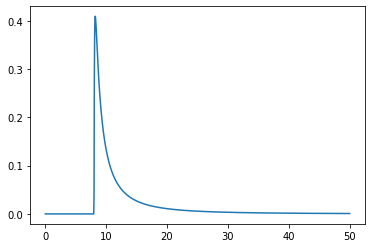

In [20]:
import scipy.stats

x=np.linspace(0,50,1000)
m=2.0
s=1.5
t=8.0

lnorm=scipy.stats.lognorm.pdf(x,s,t,m)

lognorm=np.exp(-(np.log((x-t)/m)**2/(2*s**2)))/((x-t)*s*np.sqrt(2*np.pi))
where_are_NaNs = np.isnan(lognorm)
lognorm[where_are_NaNs] = 0.0

plt.plot(x,lognorm)

In [21]:
with pm.Model() as model:
    mval = pm.Uniform('mval',lower=0.0,upper=5.0)#pm.Bound(pm.Normal, lower=0.0, upper=10.0)('mval', mu=5.0, sigma=5.0)
    sval = pm.Uniform('sval',lower=0.0,upper=4.0)#pm.Bound(pm.Normal, lower=0.0, upper=5.0)('sval',mu=2.0,sigma=2.0)
    tval = pm.Uniform('tval',lower=5.0,upper=10.0)#pm.Bound(pm.Normal, lower=0.0, upper=10.0)('tval', mu=5.0, sigma=5.0)
    
    LN = tt.exp(-tt.log((x-tval)/mval)**2/(2*sval**2))/((x-tval)*sval*tt.sqrt(2*np.pi))
    LN = tt.switch(tt.isnan(LN), 0.0, LN)
    
    y_ = pm.Normal("y", mu=LN, observed=lognorm)

    trace = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tval, sval, mval]
Sampling 4 chains: 100%|██████████| 8000/8000 [04:19<00:00, 30.81draws/s] 
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7203371457878204, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.673535391054847, but should be close to 0.8. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of ef

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mval,3.293675,1.071062,0.035865,1.379344,4.993196,813.789910,1.002699
sval,1.521639,0.777512,0.053859,0.142557,3.256857,27.291787,1.051586
tval,7.414438,1.299415,0.058290,5.004960,9.577305,166.301132,1.011949


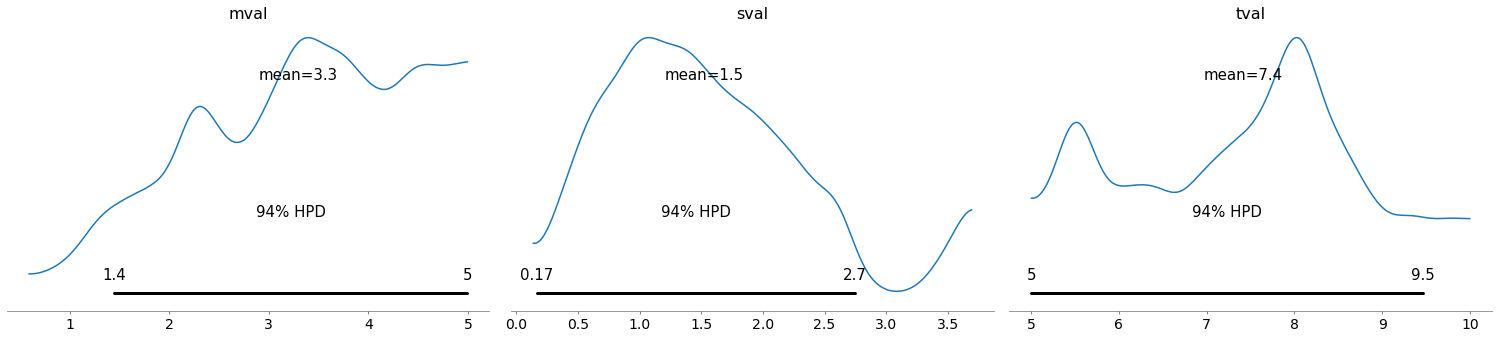

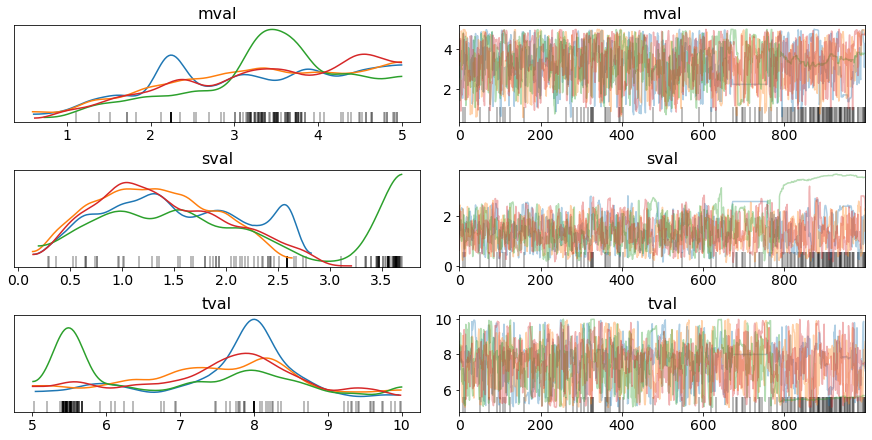

In [22]:
pm.plot_posterior(trace)
pm.traceplot(trace)
pm.summary(trace)

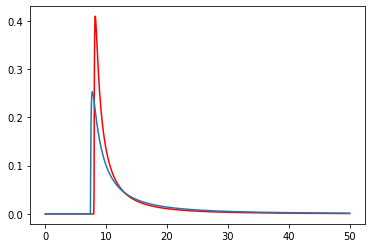

In [24]:
mval=np.mean(trace['mval'])
sval=np.mean(trace['sval'])
tval=np.mean(trace['tval'])

LNNew = np.exp(-(np.log((x-tval)/mval)**2/(2*sval**2)))/((x-tval)*sval*np.sqrt(2*np.pi))
where_are_NaNsLN = np.isnan(LNNew)
LNNew[where_are_NaNsLN] = 0.0

plt.plot(x,lognorm,'r')
plt.plot(x,LNNew)

In [25]:
ppc = pm.sample_posterior_predictive(trace, model=model)

100%|██████████| 4000/4000 [00:19<00:00, 201.26it/s]


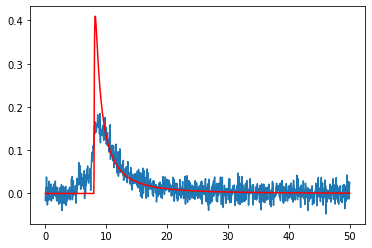

In [26]:

#plt.plot(x,ppc['y'])
#print(ppc['y'].size)
mu = np.zeros(len(x))
sd = np.zeros(len(x))

for i in range(0,len(x)):
    mu[i] = np.mean(ppc['y'][:,i])
    sd[i] = np.std(ppc['y'][:,i])


plt.plot(x,mu)
#plt.plot(x,ppc['y'][-1,:])
plt.plot(x,lognorm,'r')
#plt.plot(x, mu + sd, 'r', lw=1); plt.plot(x, mu - sd, 'r', lw=1);
#plt.fill_between(x.flatten(), mu - sd, mu + sd, color="r", alpha=0.5)